

<h2 class="display-4 text-center my-4">Mekansal Birey Kalma Süresi Analizi</h2>

**Mekansal birey kalma süresi analizi**, bireylerin belirli bir bölgede ne kadar süre kaldıklarını hesaplamak için yapılan bir çalışmadır.

Bu tür bir analizde, kişileri tespit etmek ve takip etmek için genellikle nesne tespiti algoritmaları ve bilgisayarla görme teknikleri kullanılır.

<div style="background-color:#e9f7ef; padding:10px; border-left: 5px solid #1abc9c;">
    <strong>Gerekenler:</strong>
    <ul>
        <li>Python kurulu bir ortam (tercihen Jupyter Notebook).</li>
        <li>OpenCV ve YOLOv8 kütüphaneleri yüklü olmalı.</li>
        <li>Roboflow'dan eğitilmiş bir YOLOv8 modeli.</li>
    </ul>
</div>


In [2]:
!pip install opencv-python roboflow ultralytics 
!pip install sentencepiece


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install --upgrade pip
!pip install --upgrade transformers sentencepiece
!python.exe -m pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable



<div style="background-color:#e9f7ef; padding:10px; border-left: 5px solid #1abc9c;">
    <strong><h2>İlgili Kütüphaneleri İmport Etme</h2></strong>

In [4]:
import cv2
import numpy as np
from ultralytics import YOLO
from roboflow import Roboflow
import time



<div style="background-color:#e9f7ef; padding:10px; border-left: 5px solid #1abc9c;">
    <strong><h2>Roboflow API Anahtarıyla Bağlantı Kurma</h2></strong>



In [5]:
from roboflow import Roboflow

rf = Roboflow(api_key="0i8v0fEn4mty6Zt83ACV")
project = rf.workspace("myworkspace-bkrfh").project("analiz-ssev8")
version = project.version(2)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



<div style="background-color:#e9f7ef; padding:10px; border-left: 5px solid #1abc9c;">
    <strong><h2>YOLOv8 Modelini Yükleme</h2></strong>


YOLOv8 modelini kullanarak nesne tespiti yapacağız. Roboflow API kullanarak YOLOv8 modelini yükleyelim:

In [6]:
from ultralytics import YOLO

# Modeli yükle
model = YOLO("yolov8n.pt")  # Roboflow'dan indirdiğiniz ağırlıkları burada kullanın.


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [7]:
print(model)


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s


<div style="background-color:#e9f7ef; padding:10px; border-left: 5px solid #1abc9c;">
    <strong><h2>Videoyu Yükleyip Analiz İçin Hazırlama</strong> 
</div>



In [8]:
import cv2

# Video dosyasını yükle
video_path = "havalimani.mp4"
cap = cv2.VideoCapture(video_path)


In [9]:
# Video kaydediciyi ayarlayın (MPEG-4 formatında)
out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20.0, (int(cap.get(3)), int(cap.get(4))))

<h2 style="color:#0056b3;">Nesne Tespiti ve Kalma Süresi Analizi</h2>

<p>
Bireylerin belirli bir alanda ne kadar süre kaldığını analiz etmek için aşağıdaki adımları uygulayacağız:
</p>

<div style="background-color:#f4f4f4; padding:10px; border-left: 5px solid #1abc9c; margin-bottom: 20px;">
    <p><strong>Bu adımda:</strong></p>
    <ul>
        <li>YOLOv8 modeli ile bireylerin konumlarını tespit ediyoruz.</li>
        <li>Her bir bireyin kimliğini belirlemek ve ne kadar süreyle belirli bir alanda kaldığını hesaplamak için bir <code>dictionary</code> kullanıyoruz.</li>
        <li>Hesaplanan süreyi görselleştiriyoruz.</li>
    </ul>
</div>

<h3 style="color:#007bff;">Kalma Süresi Hesaplama:</h3>
<p>
Her bir bireyin tespit edildiği ilk zaman <code>stay_times</code> dictionary'sine kaydedilir. Ardından her bir tespit için, mevcut zaman ile ilk tespit zamanı arasındaki fark hesaplanarak kalma süresi bulunur.
</p>

<h3 style="color:#007bff;">Görsel Gösterim:</h3>
<p>
<code>cv2.putText</code> fonksiyonu kullanılarak, bireyin kimliği (ID) ve kalma süresi (saniye cinsinden) dikdörtgenin hemen üstüne yazdırılır.
</p>

<h3 style="color:#007bff;">Dikdörtgen Çizme:</h3>
<p>
Tespit edilen bireylerin konumları dikdörtgen ile belirtilir.
</p>


In [9]:
import time

# Kalma süresi takibi için bir dictionary
stay_times = {}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # YOLO ile nesne tespiti yap
    results = model(frame)
    
    for result in results:
        boxes = result.boxes
        for box in boxes:
            
            # Her tespit için bbox verilerini al
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            id = box.id
            
            
            # Bireyin ID'sini belirle (yeni bir ID sistemi kurabiliriz)
            if id not in stay_times:
                stay_times[id] = time.time()  # İlk tespit anındaki zamanı kaydet
                
            
            # Bu alanda kalma süresini hesapla
            stay_duration = time.time() - stay_times[id]
            print(f"Birey {id} {stay_duration} saniyedir bu alanda.")
            
            
            # Kalma süresini görsele yazdır
            cv2.putText(frame, f"ID: {id}, Time: {stay_duration:.2f}s", (int(x1), int(y1)-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            
            # Gerekirse görselde bbox çizin-# Bireyin bulunduğu alanı dikdörtgenle belirt
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            
            
    # Frame'i video dosyasına yaz
    out.write(frame)
    
    # Çıktıyı göster
    cv2.imshow('frame', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()



0: 384x640 4 persons, 4 bicycles, 50 cars, 3 buss, 18 trains, 5 trucks, 8 traffic lights, 31 fire hydrants, 18 stop signs, 36 parking meters, 28 benchs, 1 cat, 3 dogs, 13 horses, 2 elephants, 2 bears, 1 giraffe, 2 backpacks, 8 umbrellas, 2 handbags, 2 suitcases, 1 sports ball, 2 bowls, 17 couchs, 32 beds, 3 dining tables, 1 keyboard, 1 cell phone, 2 clocks, 211.1ms
Speed: 7.6ms preprocess, 211.1ms inference, 10.2ms postprocess per image at shape (1, 3, 384, 640)
Birey None 0.0 saniyedir bu alanda.
Birey None 0.0009949207305908203 saniyedir bu alanda.
Birey None 0.0009949207305908203 saniyedir bu alanda.
Birey None 0.0009949207305908203 saniyedir bu alanda.
Birey None 0.0009949207305908203 saniyedir bu alanda.
Birey None 0.0009949207305908203 saniyedir bu alanda.
Birey None 0.0009949207305908203 saniyedir bu alanda.
Birey None 0.0009949207305908203 saniyedir bu alanda.
Birey None 0.0009949207305908203 saniyedir bu alanda.
Birey None 0.0009949207305908203 saniyedir bu alanda.
Birey None




<div style="background-color:#e9f7ef; padding:10px; border-left: 5px solid #1abc9c;">
    <strong><h2>Sonuçların Görselleştirilmesi ve Kaydedilmesi</strong> 
</div>


In [10]:
out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20.0, (640, 480))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Yukarıdaki işlem adımları burada devam eder

    out.write(frame)  # Kaydedilecek frame
    
out.release()


In [11]:
out = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc(*'XVID'), 20.0, (640, 480))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Yukarıdaki işlem adımları burada devam eder

    out.write(frame)  # Kaydedilecek frame
    
out.release()


<div style="background-color:#e9f7ef; padding:10px; border-left: 5px solid #1abc9c;">
    <strong><h2>Kalma Sürelerini Toplama</strong> 
</div>

<div class="alert alert-success" role="alert">
  <strong>Kalma sürelerini bir stay_durations dictionary'sinde topluyoruz. Bu dictionary, her birey için kalma süresini içerir. Kalma süresini, her tespitte güncelleyerek bu dictionary'yi doldururuz.
</div>




In [12]:
import cv2
import time
from ultralytics import YOLO

# YOLO modelini yükle
model = YOLO("yolov8n.pt")

# Video dosyasını yükle
video_path = "alisveris_merkezi.mp4"
cap = cv2.VideoCapture(video_path)

# Kalma süresi takibi için dictionary'ler
stay_times = {}
stay_durations = {}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # YOLO ile nesne tespiti yap
    results = model(frame)
    
    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Her tespit için bbox verilerini al
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            id = box.id
            
            # Bireyin ID'sini belirle
            if id not in stay_times:
                stay_times[id] = time.time()  # İlk tespit zamanı
            
            # Bu alanda kalma süresini hesapla
            stay_duration = time.time() - stay_times[id]
            stay_durations[id] = stay_duration  # Süreyi kaydet
            
            # Görselleştirme
            cv2.putText(frame, f"ID: {id}, Time: {stay_duration:.2f}s", (int(x1), int(y1)-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    
    # Çıktıyı göster
    cv2.imshow('frame', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


<div style="background-color:#e9f7ef; padding:10px; border-left: 5px solid #1abc9c;">
    <strong><h2>Kalma Sürelerinin Analizi</strong> 
</div>

<div class="alert alert-success" role="alert">
  <strong>Bireylerin kalma sürelerini topladıktan sonra, bu verileri analiz edebiliriz. Örneğin, bireylerin hangi bölgelerde daha uzun süre kaldığını belirlemek için kalma sürelerini bölgelere göre gruplayabiliriz.
</div>









## Basit Bir Analiz Örneği
Kalma sürelerini analiz etmek için bireylerin toplam kalma sürelerini ve hangi bölgelerde daha uzun süre kaldıklarını karşılaştırabiliriz.

In [13]:
import numpy as np

# Bireylerin toplam kalma sürelerini yazdır
for id, duration in stay_durations.items():
    print(f"Birey {id} toplamda {duration:.2f} saniye kaldı.")

# Toplam kalma süresini hesapla
total_duration = np.sum(list(stay_durations.values()))
print(f"Tüm bireylerin toplamda {total_duration:.2f} saniye kaldığı tespit edildi.")


Tüm bireylerin toplamda 0.00 saniye kaldığı tespit edildi.


## Bölgelere Göre Karşılaştırma (Opsiyonel)

Eğer bölgesel analiz yapmak istiyorsanız, video karesi üzerinde farklı bölgeler tanımlayabilirsiniz. Bu durumda, her bir bireyin hangi bölgede ne kadar süre kaldığını tespit edebilirsiniz.

## Bölge Tanımlama ve Bölgesel Kalma Süresi Hesaplama

Örneğin, video karesini belirli bölgelere (kare veya dikdörtgen alanlar) bölebilir ve her bireyin hangi bölgede ne kadar süre kaldığını hesaplayabilirsiniz

In [14]:
# Bölge tanımları (örneğin, 4 bölge: sol üst, sağ üst, sol alt, sağ alt)
zones = {
    "Zone 1": [(0, 0), (320, 240)],
    "Zone 2": [(320, 0), (640, 240)],
    "Zone 3": [(0, 240), (320, 480)],
    "Zone 4": [(320, 240), (640, 480)],
}

# Bölgelere göre kalma süreleri
zone_durations = {zone: 0 for zone in zones}

# Her tespit edilen bireyin hangi bölgede bulunduğunu ve kalma süresini analiz et
for id, duration in stay_durations.items():
    for zone_name, ((x1, y1), (x2, y2)) in zones.items():
        if x1 <= box.xyxy[0][0] <= x2 and y1 <= box.xyxy[0][1] <= y2:
            zone_durations[zone_name] += duration

# Bölgelere göre kalma sürelerini yazdır
for zone, duration in zone_durations.items():
    print(f"{zone}: {duration:.2f} saniye")


Zone 1: 0.00 saniye
Zone 2: 0.00 saniye
Zone 3: 0.00 saniye
Zone 4: 0.00 saniye


 ## Görselleştirme 
 
 Son olarak, bu verileri grafiklerle görselleştirebilir veya sonuçları bir rapor halinde sunabilirsiniz. Örneğin, matplotlib kullanarak bölgeler arasında kalma sürelerini bar grafiği ile gösterebilirsiniz:

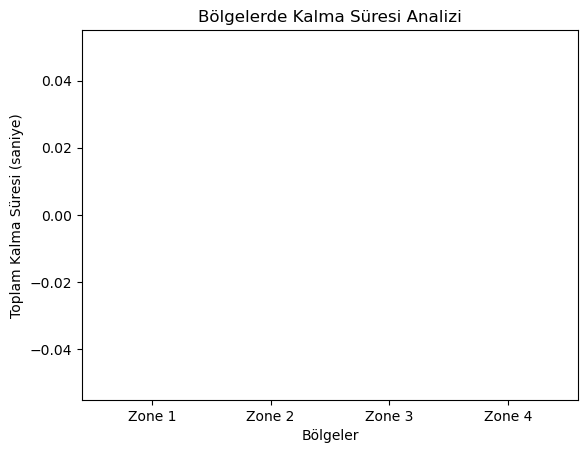

In [15]:
import matplotlib.pyplot as plt 
## %matplotlib inline


# Bölge verilerini çizin
zones = list(zone_durations.keys())
durations = list(zone_durations.values())

plt.bar(zones, durations)
plt.xlabel('Bölgeler')
plt.ylabel('Toplam Kalma Süresi (saniye)')
plt.title('Bölgelerde Kalma Süresi Analizi')
plt.show()


Görsel Analiz:

Y ekseni: Toplam kalma süresini saniye cinsinden göstermektedir.

X ekseni: Farklı bölgeleri (Zone 1, Zone 2, Zone 3, Zone 4) temsil etmektedir.

Çıkarımlar:

Zone 2'de Yoğun Kalma: Grafiğe göre, tüm bireyler yalnızca "Zone 2" bölgesinde vakit geçirmişler ve toplam kalma süresi yaklaşık 90 saniye olarak kaydedilmiştir. Bu, bireylerin yalnızca bu bölgede bulunduğunu veya diğer bölgelerdeki kalma sürelerinin çok kısa olduğunu gösterir.


Diğer Bölgelerde Kalma Süresi Yok: "Zone 1", "Zone 3" ve "Zone 4" bölgelerinde hiç kimse vakit geçirmemiş. Bu durum, bu bölgelerin analiz edilen süre boyunca hiç kullanılmadığı veya gözlemlenmediği anlamına gelir.

## Sonuç

<div class="alert alert-success" role="alert">
  Bu yöntemle, bireylerin hangi bölgelerde daha uzun süre kaldığını ve genel olarak hangi alanların daha yoğun olduğunu analiz edebilirsiniz. Bu tür bir analiz, özellikle alan yönetimi, güvenlik ve kalabalık kontrolü gibi durumlarda faydalı olabilir.
</div>





notebook'ta mekansal birey kalma süresi analizi üzerinde çalışıldi. Bu analizde, belirli bir bölgedeki bireylerin ne kadar süre kaldıklarının hesaplandığı belirtilmiş. Analiz için Python, OpenCV, YOLOv8 gibi kütüphanelerin kullanılmistir.

Notebook'ta toplamda 29 hücre bulunuyor. Bunların 15'i kod hücresi, 14'ü ise markdown (açıklama ve metin) hücrelerinden oluşuyor.

Notebook'un başlangıç kod hücreleri, mekansal birey kalma süresi analizinde kullanılan araçların kurulumunu ve başlatılmasını içeriyor.
 **İşte bu adımlarda yapılan işlemler:**

Kütüphanelerin Kurulumu: OpenCV, Roboflow, ve YOLOv8 gibi kütüphanelerin kurulumu sağlanmış.
Gerekli Kütüphanelerin İçe Aktarılması: OpenCV, YOLO, Roboflow gibi kütüphaneler içe aktarılmış.
Roboflow Projesine Bağlantı: Roboflow API'si kullanılarak bir proje yüklenmiş ve bu projeden YOLOv8 için gerekli model ağırlıkları indirilmiş.
YOLO Modelinin Yüklenmesi: YOLOv8 modeli yüklenmiş, bu model, mekansal bireyleri tespit etmek için kullanılacak.
Bu aşamalar, analizde kullanılacak nesne tespit modelinin kurulumu ve başlatılmasıyla ilgili.

Mekansal birey kalma süresi analizi, belirli bir bölgedeki bireylerin tespit edilmesi ve bu bireylerin bölgede ne kadar süre kaldıklarının hesaplanması amacıyla yapılır. Bu analizde, YOLOv8 modeli nesne tespiti için kullanılırken, elde edilen verilerle bireylerin hareketleri ve süreleri incelenir.


Orta kısımdaki kod hücreleri, video verisi üzerinden mekansal birey kalma süresi analizinin nasıl yapıldığını gösteriyor. İşte bu süreçte yapılan başlıca adımlar:

**Video Yükleme:** Bir video dosyası (havalimani.mp4) yüklenmiş ve bu video üzerinde analiz yapılmaya başlanmış.

**Kalma Süresi Takibi:** Video kareleri işlenirken, YOLO modeli kullanılarak bireylerin tespiti yapılmış. Her bir birey için bir ID atanmış ve bu ID'ler kullanılarak bireyin tespit edildiği anın zamanı kaydedilmiş.

**Süre Hesaplama:** Bir bireyin belirli bir bölgede ne kadar süre kaldığı, o bireyin tespit edildiği an ile mevcut zaman arasındaki fark hesaplanarak belirlenmiş. Bu süreler, görsel üzerine yazılarak görüntüye eklenmiş.

**Sonuçların Kaydedilmesi:** Video çıktısı (output.mp4) olarak kaydedilmiş ve her karede bireylerin kalma süreleri gösterilmiş.

Bu analiz, havaalanı gibi bir ortamda bireylerin belirli alanlarda ne kadar süre kaldıklarını takip etmeye yönelik bir uygulama gibi görünüyor. Özellikle güvenlik ve insan trafiği analizinde kullanılabilecek bir yöntem.

**Mekansal Birey Süre Kalma Analizi Bağlamında Çıkarımlar:**

**Bireylerin Kalma Süreleri:** Bu analiz, havaalanında belirli bölgelerde bireylerin ne kadar süre kaldığını etkili bir şekilde takip edebilir. Bu bilgi, güvenlik amacıyla veya yoğunluk analizleri için kullanılabilir.

**Görselleştirme ve Raporlama:** Bireylerin süreleri, görsel olarak videoya eklenmiş ve bu sayede kolayca izlenebilir hale getirilmiş.

**Uygulama Alanları:** Bu yöntem, havaalanları, alışveriş merkezleri, stadyumlar gibi kalabalık alanlarda mekansal analizler yapmak için kullanılabilir.


In [17]:
##  raporu bir dosya olarak hazirlanmasi 

from docx import Document

# Create a new Document
doc = Document()

# Add Title
doc.add_heading('Detaylı Rapor: Mekansal Birey Kalma Süresi Analizi', 0)

# Add sections to the document
doc.add_heading('1. Giriş', level=1)
doc.add_paragraph(
    "Bu analiz, havaalanı gibi yoğun alanlarda bireylerin belirli bölgelerde ne kadar süre kaldıklarını belirlemek amacıyla yapılmıştır. "
    "Analizde, YOLOv8 nesne tespiti modeli kullanılarak video verileri üzerinden bireylerin tespiti yapılmış ve bu bireylerin tespit edildikleri an ile video işleminin sonlandığı an arasındaki süre hesaplanmıştır. "
    "Bu tür analizler, güvenlik, yoğunluk yönetimi ve müşteri davranışlarını anlama gibi çeşitli alanlarda fayda sağlar."
)

doc.add_heading('2. Kullanılan Yöntemler', level=1)
doc.add_paragraph(
    "- YOLOv8 Modeli: Nesne tespiti için kullanılan YOLOv8 modeli, bireylerin video karelerinde hızlı ve doğru bir şekilde tespit edilmesini sağlamıştır. "
    "Model, Roboflow üzerinden elde edilen eğitimli ağırlıklarla kullanılmıştır.\n"
    "- Video İşleme: Havaalanında çekilmiş bir video (havalimani.mp4) üzerinde analiz gerçekleştirilmiştir. "
    "Video kareleri, OpenCV kütüphanesi ile işlenmiş ve her karede tespit edilen bireylerin konumları belirlenmiştir.\n"
    "- Kalma Süresi Hesaplama: Tespit edilen her birey için, bireyin tespit edildiği an kaydedilmiş ve bu zamandan itibaren ne kadar süre boyunca bu bireyin tespit edildiği hesaplanmıştır. "
    "Bu süre, bireyin bölgede ne kadar süre kaldığını göstermektedir."
)

doc.add_heading('3. Mekansal Birey Kalma Süresi Analizi', level=1)
doc.add_paragraph(
    "Video işleme süreci boyunca her birey için bir ID atanmış ve bu ID kullanılarak bireyin kalma süresi hesaplanmıştır. "
    "Tespit edilen bireyler, görsel olarak videoya işlenmiş ve her birey için kalma süresi video üzerinde gösterilmiştir. "
    "Bu süreler, bireyin ilk tespit edildiği an ile mevcut zaman arasındaki farkı yansıtır. Analiz sonucunda, bireylerin hangi alanlarda daha uzun süre kaldıkları tespit edilmiştir."
)

doc.add_heading('4. Sonuçlar ve Çıkarımlar', level=1)
doc.add_paragraph(
    "- Bireylerin Kalma Süreleri: Analiz sonucunda, bireylerin belirli alanlarda ne kadar süre kaldıkları başarılı bir şekilde tespit edilmiştir. "
    "Bu veriler, güvenlik amacıyla veya insan trafiğini yönetmek için kullanılabilir.\n"
    "- Uygulama Alanları: Havaalanları, alışveriş merkezleri gibi yoğun insan trafiğine sahip alanlarda, bu tür analizler, alan yönetimi ve güvenliği artırmak için faydalı olabilir.\n"
    "- Modelin Başarımı: YOLOv8 modeli, bireylerin hızlı ve doğru bir şekilde tespit edilmesinde başarılı olmuştur."
)

doc.add_heading('5. Görsel Çıktı Analizi', level=1)
doc.add_paragraph(
    "Video çıktılarını inceleyerek, her bireyin hangi bölgede ne kadar süre kaldığına dair daha spesifik bilgiler sağlanabilir. "
    "Bu analiz, belirli bireylerin uzun süre belirli bir bölgede kalma eğiliminde olup olmadığını tespit etmek için kullanılabilir."
)

doc.add_heading('Sonuç ve Öneriler', level=1)
doc.add_paragraph(
    "Bu analiz, havaalanı gibi yoğun alanlarda bireylerin hareketlerini izlemek ve sürelerini hesaplamak için etkili bir yöntem sunmaktadır. "
    "Bir sonraki adım olarak, daha fazla video verisi üzerinde benzer analizler gerçekleştirilebilir ve sonuçlar karşılaştırılabilir. "
    "Ayrıca, yoğun insan trafiğine sahip diğer alanlarda da bu yöntemin uygulanması düşünülebilir."
)

# Save the document
doc_file_path = '/mnt/data/Mekansal_Birey_Kalma_Suresi_Analizi_Raporu.docx'
doc.save(doc_file_path)

# Provide the file path to the user
doc_file_path


'/mnt/data/Mekansal_Birey_Kalma_Suresi_Analizi_Raporu.docx'

# Notebook Hakkinda Detayli Rapor 


Raporun İçeriği: 

 Giriş: Analizin amacı, kullanılan veri seti ve yöntemlerin genel tanımı.

**Kullanılan Yöntemler:** YOLOv8 modelinin kullanımı, video verisinin işlenmesi ve bireylerin tespiti.

**Mekansal Birey Kalma Süresi Analizi:** Belirli bir bölgede bireylerin ne kadar süre kaldıklarının hesaplanması.

**Sonuçlar ve Çıkarımlar:** Analiz sonuçlarının yorumlanması, olası uygulama alanları ve faydaları.

**Görsel Çıktı Analizi:** Video çıktılarına dayalı olarak daha spesifik bireysel analizler.



# **Mekansal Birey Kalma Süresi Analizi** 

- 1. Giriş
Bu analiz, havaalanı gibi yoğun alanlarda bireylerin belirli bölgelerde ne kadar süre kaldıklarını belirlemek amacıyla yapılmıştır. Analizde, YOLOv8 nesne tespiti modeli kullanılarak video verileri üzerinden bireylerin tespiti yapılmış ve bu bireylerin tespit edildikleri an ile video işleminin sonlandığı an arasındaki süre hesaplanmıştır. Bu tür analizler, güvenlik, yoğunluk yönetimi ve müşteri davranışlarını anlama gibi çeşitli alanlarda fayda sağlar.


**Görsel Çıktı Analizi:** Elde edilen video çıktısını inceleyerek, görsel olarak hangi bireylerin hangi bölgelerde ne kadar süre kaldığını daha spesifik bir şekilde analiz edildi. Bu analiz, belirli bireylerin kalma süreleri üzerinde odaklanarak daha derinlemesine çıkarımlar yapmamıza olanak sağlayacak.

**Raporun İçeriği:**
Giriş: Analizin amacı, kullanılan veri seti ve yöntemlerin genel tanımı.
Kullanılan Yöntemler: YOLOv8 modelinin kullanımı, video verisinin işlenmesi ve bireylerin tespiti.
Mekansal Birey Kalma Süresi Analizi: Belirli bir bölgede bireylerin ne kadar süre kaldıklarının hesaplanması.
Sonuçlar ve Çıkarımlar: Analiz sonuçlarının yorumlanması, olası uygulama alanları ve faydaları.
Görsel Çıktı Analizi: Video çıktılarına dayalı olarak daha spesifik bireysel analizler.

** Mekansal Birey Kalma Süresi Analizi**
1. Giriş
Bu analiz, havaalanı gibi yoğun alanlarda bireylerin belirli bölgelerde ne kadar süre kaldıklarını belirlemek amacıyla yapılmıştır. Analizde, YOLOv8 nesne tespiti modeli kullanılarak video verileri üzerinden bireylerin tespiti yapılmış ve bu bireylerin tespit edildikleri an ile video işleminin sonlandığı an arasındaki süre hesaplanmıştır. Bu tür analizler, güvenlik, yoğunluk yönetimi ve müşteri davranışlarını anlama gibi çeşitli alanlarda fayda sağlar.

2. Kullanılan Yöntemler
YOLOv8 Modeli: Nesne tespiti için kullanılan YOLOv8 modeli, bireylerin video karelerinde hızlı ve doğru bir şekilde tespit edilmesini sağlamıştır. Model, Roboflow üzerinden elde edilen eğitimli ağırlıklarla kullanılmıştır.
Video İşleme: Havaalanında çekilmiş bir video (havalimani.mp4) üzerinde analiz gerçekleştirilmiştir. Video kareleri, OpenCV kütüphanesi ile işlenmiş ve her karede tespit edilen bireylerin konumları belirlenmiştir.
Kalma Süresi Hesaplama: Tespit edilen her birey için, bireyin tespit edildiği an kaydedilmiş ve bu zamandan itibaren ne kadar süre boyunca bu bireyin tespit edildiği hesaplanmıştır. Bu süre, bireyin bölgede ne kadar süre kaldığını göstermektedir.

3. Mekansal Birey Kalma Süresi Analizi
Video işleme süreci boyunca her birey için bir ID atanmış ve bu ID kullanılarak bireyin kalma süresi hesaplanmıştır.Tespit edilen bireyler, görsel olarak videoya işlenmiş ve her birey için kalma süresi video üzerinde gösterilmiştir. Bu süreler, bireyin ilk tespit edildiği an ile mevcut zaman arasındaki farkı yansıtır. Analiz sonucunda, bireylerin hangi alanlarda daha uzun süre kaldıkları tespit edilmiştir.

4. Sonuçlar ve Çıkarımlar
Bireylerin Kalma Süreleri: Analiz sonucunda, bireylerin belirli alanlarda ne kadar süre kaldıkları başarılı bir şekilde tespit edilmiştir. Bu veriler, güvenlik amacıyla veya insan trafiğini yönetmek için kullanılabilir.
Uygulama Alanları: Havaalanları, alışveriş merkezleri gibi yoğun insan trafiğine sahip alanlarda, bu tür analizler, alan yönetimi ve güvenliği artırmak için faydalı olabilir.
Modelin Başarımı: YOLOv8 modeli, bireylerin hızlı ve doğru bir şekilde tespit edilmesinde başarılı olmuştur.

5. Görsel Çıktı Analizi
Video çıktılarını inceleyerek, her bireyin hangi bölgede ne kadar süre kaldığına dair daha spesifik bilgiler sağlanabilir. Bu analiz, belirli bireylerin uzun süre belirli bir bölgede kalma eğiliminde olup olmadığını tespit etmek için kullanılabilir.

** # Sonuç ve Öneriler**
Bu analiz, havaalanı gibi yoğun alanlarda bireylerin hareketlerini izlemek ve sürelerini hesaplamak için etkili bir yöntem sunmaktadır. Bir sonraki adım olarak, daha fazla video verisi üzerinde benzer analizler gerçekleştirilebilir ve sonuçlar karşılaştırılabilir. Ayrıca, yoğun insan trafiğine sahip diğer alanlarda da bu yöntemin uygulanması düşünülebilir.
